In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from analysis.Base import AnalysisBase
from analysis.Order import OrderParameters
from analysis.Vector import VectorOrientation
from analysis import Surface
from analysis import MembraneBase
import analysis.opc
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import logging

In [2]:
u = mda.Universe('../data/6.6_2.gro', '../data/rep1_skip100.xtc')

# Scd for PL membrane. Includes distances from protein

In [7]:
base = MembraneBase.MembraneAnalysisBase(u, ['POPC'], 'TRIO', 'TIP3')  # no need to run anything

start_frame = 1
end_frame = 10
atomlists = analysis.opc.POPC1

# Selections
selection_near = base.select_near_protein("POPC", 10)
selection_donut = base.select_near_protein("POPC", 20, inner_distance=10)
selection_far = base.select_near_protein("POPC", 30, inner_distance=20)
selection_opp_leaflet = f"resname POPC and prop z < {base.halfz}"
selection_bulk = f"resname POPC and prop z > {base.halfz}"  # all upper leaflet

def run_op(selection):
    op = OrderParameters(u, atomlists=atomlists, selection=selection, start=start_frame, stop=end_frame)
    op.run()
    return op.results['output']

res_near = run_op(selection_near)
res_donut = run_op(selection_donut)
res_far = run_op(selection_far)
res_opp_leaflet = run_op(selection_opp_leaflet)
res_bulk = run_op(selection_bulk)




OrderParameters: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.71it/s]


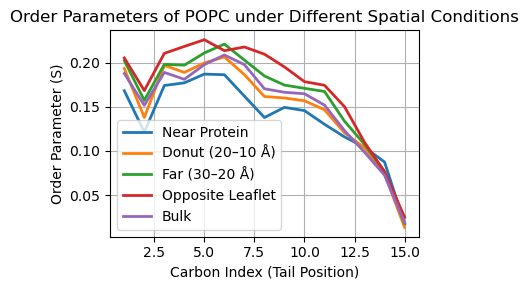

In [8]:
# Plot all results
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
for res, label in zip(
    [res_near, res_donut, res_far, res_opp_leaflet, res_bulk],
    ["Near Protein", "Donut (20–10 Å)", "Far (30–20 Å)", "Opposite Leaflet", "Bulk"]
):
    plt.plot(res[:, 0], res[:, 1], label=label, lw=2)


plt.xlabel("Carbon Index (Tail Position)")
plt.ylabel("Order Parameter (S)")
plt.title("Order Parameters of POPC under Different Spatial Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# For SURF-TG


In [3]:
from analysis.utils import make_dynamic_residue

interdig_analysis = Surface.InterdigitationAnalysis(u, lipids=['POPC', 'DOPE', 'SAPI'], NL='TRIO', water='TIP3')
interdig_analysis.start = 50
interdig_analysis.stop = 100
interdig_analysis.run()
strong_u = interdig_analysis.results['strong_residues']

get_dynamic_strong_residues = make_dynamic_residue(strong_u, start_frame=50)

op = OrderParameters(
    u,
    atomlists=analysis.opc.TRIO1,
    selection=None,
    get_strong_residues=get_dynamic_strong_residues,
    start=50,
    stop=100
)
op.run()


OrderParameters: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.12it/s]


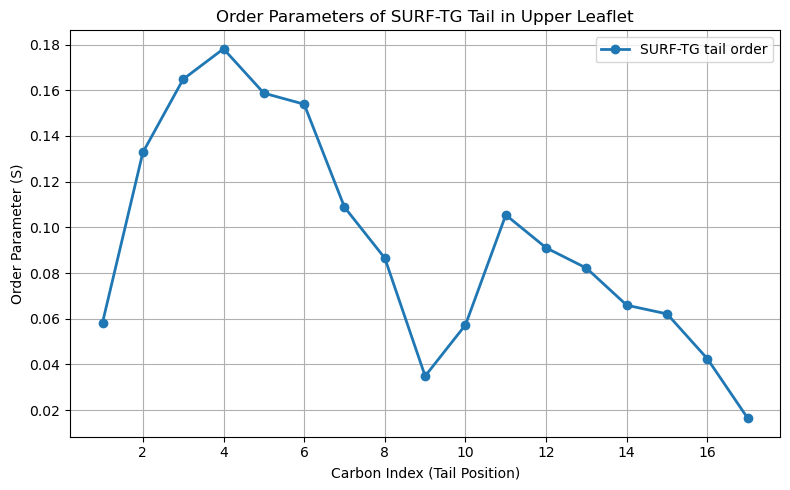

In [5]:
surf_results = op.results['output']  # shape: (N_carbon_atoms, 2)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(surf_results[:, 0], surf_results[:, 1], marker='o', lw=2, label='SURF-TG tail order')

plt.xlabel("Carbon Index (Tail Position)")
plt.ylabel("Order Parameter (S)")
plt.title("Order Parameters of SURF-TG Tail in Upper Leaflet")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Cosine alignment

In [6]:
vo = VectorOrientation(
    universe=u,
    start=0,
    stop=10,
    step=1,
    residue_sel="resname TRIO",
    tail_names=["C118", "C218", "C318"],
    headgroup_sel="name O*",
    pl_selection="resname POPC DOPE and name C210",
    leaflet='bottom',
    expected_headgroup_count=6
)


angles, time_series, avg_op, std_op = vo.run().unpack()



VectorOrientation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.72it/s]


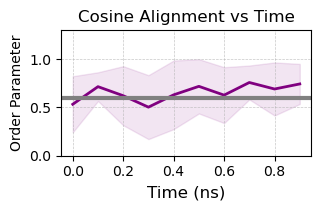

In [7]:
tail_names = ["C118", "C218", "C318"]
avg_values_combined = np.nanmean([np.array(avg_op[tail]) for tail in tail_names], axis=0)
std_values_combined = np.nanmean([np.array(std_op[tail]) for tail in tail_names], axis=0)
time_series_array = np.array(time_series)
valid_mask = ~np.isnan(avg_values_combined)

# Create plot
plt.figure(figsize=(3.4, 2.2))
plt.plot(
    time_series_array[valid_mask] / 10,  # convert to ns
    avg_values_combined[valid_mask],
    color='purple',
    linewidth=2
)
plt.fill_between(
    time_series_array[valid_mask] / 10,
    avg_values_combined[valid_mask] - std_values_combined[valid_mask],
    avg_values_combined[valid_mask] + std_values_combined[valid_mask],
    color='purple',
    alpha=0.1
)

plt.axhline(0.6, color='gray', linestyle='-', linewidth=3)

plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Order Parameter", fontsize=10)
plt.title("Cosine Alignment vs Time", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()
